In [1]:
# 📦 环境依赖（首次运行请取消注释安装）
# !pip install selenium pandas webdriver-manager

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import os
import re

# 🕸️ 爬虫函数：抓取万柳租房前 max_pages 页数据
def crawl_rent_data(url, max_pages=20):
    options = webdriver.ChromeOptions()
    options.add_argument("--disable-gpu")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    driver.get(url)
    WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div.houseList'))
    )

    data_list = []
    current_page = 1

    while current_page <= max_pages:
        listings = driver.find_elements(By.CSS_SELECTOR, 'div.houseList dl')
        for item in listings:
            full_text = item.text.strip()
            if full_text:
                data_list.append({
                    "页码": current_page,
                    "房源完整信息": full_text
                })
        try:
            next_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//a[contains(text(), "下一页")]'))
            )
            next_button.click()
            current_page += 1
        except (NoSuchElementException, TimeoutException):
            break

    driver.quit()
    return pd.DataFrame(data_list)

# 🧼 数据清洗函数：提取名称、面积、租金、单价
def clean_rent_data(df_raw):
    pattern_name = r"^(.*?)\s+整租"
    pattern_area = r"(\d+\.?\d*)㎡"
    pattern_price = r"(\d+,?\d*)元/月"

    data_list = []
    for _, row in df_raw.iterrows():
        full_text = row['房源完整信息']
        name = re.search(pattern_name, full_text)
        area = re.search(pattern_area, full_text)
        price = re.search(pattern_price, full_text)

        name = name.group(1) if name else "未知"
        area = area.group(1) if area else "未知"
        price = price.group(1) if price else "未知"

        try:
            area_val = float(area)
            price_val = float(price.replace(",", ""))
            unit_price = round(price_val / area_val, 2)
        except:
            unit_price = "未知"

        data_list.append({
            "名称": name,
            "面积(㎡)": area,
            "租金(元/月)": price,
            "单价(元/㎡)": unit_price
        })

    return pd.DataFrame(data_list)

# 🚀 主入口：一键运行
if __name__ == "__main__":
    url = 'https://zu.fang.com/house-a015277-b02313/'
    df_raw = crawl_rent_data(url)
    df_cleaned = clean_rent_data(df_raw)

    os.makedirs("output", exist_ok=True)
    df_cleaned.to_csv("output/万柳租房.csv", index=False, encoding="utf-8-sig")
    print(f"✅ 数据处理完成，共 {len(df_cleaned)} 条房源。")
    print("📂 文件已保存至：output/万柳租房.csv")


✅ 数据处理完成，共 1200 条房源。
📂 文件已保存至：output/万柳租房.csv


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import pandas as pd
import os
import time
import re

# 🕸️ 爬虫函数：抓取二手房网站数据
def crawl_ershoufang_data(url, max_pages=20):
    # 初始化浏览器
    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")
    driver = webdriver.Chrome(options=options)
    
    driver.get(url)
    WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div.shop_list.shop_list_4'))
    )

    data_list = []
    current_page = 1

    print("🚀 开始爬取二手房前 20 页全部信息...\n")

    # 主循环：爬取前 max_pages 页
    while current_page <= max_pages:
        print(f"\n📄 正在抓取第 {current_page} 页...")

        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        try:
            listings = driver.find_elements(By.CSS_SELECTOR, 'div.shop_list.shop_list_4 dl')
            print(f"本页房源数：{len(listings)}")

            for item in listings:
                try:
                    full_text = item.text.strip()
                    if full_text:
                        data_list.append({
                            "页码": current_page,
                            "房源完整信息": full_text
                        })
                except Exception:
                    continue

            try:
                next_button = WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.XPATH, '//a[contains(text(), "下一页")]'))
                )
                driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
                driver.execute_script("window.scrollBy(0, -100);")
                driver.execute_script("arguments[0].click();", next_button)

                current_page += 1
                time.sleep(2)
            except (NoSuchElementException, TimeoutException):
                print(f"❌ 第 {current_page} 页未找到“下一页”，提前结束。")
                break

        except Exception as e:
            print(f"⚠️ 抓取第 {current_page} 页出错: {e}")
            break

    driver.quit()
    return pd.DataFrame(data_list)

# 🧼 数据清洗函数：提取名称、面积、总价、单价
def clean_ershoufang_data(df_raw):
    pattern_area = r"(\d+\.?\d*)㎡"
    pattern_price = r"(\d+\.?\d*)万"
    pattern_unit = r"(\d+\.?\d*)元/㎡"

    data_list = []
    for _, row in df_raw.iterrows():
        full_text = str(row['房源完整信息'])

        area_match = re.search(pattern_area, full_text)
        area = area_match.group(1) if area_match else "未知"

        price_match = re.search(pattern_price, full_text)
        price = price_match.group(1) if price_match else "未知"

        unit_match = re.search(pattern_unit, full_text)
        unit_price = unit_match.group(1) if unit_match else "未知"

        if area_match:
            area_start = area_match.start()
            name = full_text[:area_start].strip()
        else:
            name = "未知"

        data_list.append({
            "名称": name,
            "面积(㎡)": area,
            "总价(万)": price,
            "单价(元/㎡)": unit_price
        })

    df_cleaned = pd.DataFrame(data_list)
    return df_cleaned

# 🚀 主入口：封装整个流程
def crawl_and_clean_ershoufang(url, max_pages=20, output_path="万柳二手房.csv"):
    # 爬取二手房数据
    df_raw = crawl_ershoufang_data(url, max_pages)
    
    # 清洗数据
    df_cleaned = clean_ershoufang_data(df_raw)
    
    # 保存结果
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_cleaned.to_csv(output_path, index=False, encoding="utf-8-sig")
    print(f"✅ 数据提取完成，共 {len(df_cleaned)} 条房源。")
    print(f"📂 文件已保存为：{output_path}")

# 🚀 调用示例
if __name__ == "__main__":
    url = 'https://esf.fang.com/house-a015277-b02313/'  # 二手房页面
    crawl_and_clean_ershoufang(url, max_pages=20, output_path="output/万柳二手房.csv")


🚀 开始爬取二手房前 20 页全部信息...


📄 正在抓取第 1 页...
本页房源数：60

📄 正在抓取第 2 页...
本页房源数：60

📄 正在抓取第 3 页...
本页房源数：60

📄 正在抓取第 4 页...
本页房源数：60

📄 正在抓取第 5 页...
本页房源数：60

📄 正在抓取第 6 页...
本页房源数：60

📄 正在抓取第 7 页...
本页房源数：60

📄 正在抓取第 8 页...
本页房源数：60

📄 正在抓取第 9 页...
本页房源数：60

📄 正在抓取第 10 页...
本页房源数：60

📄 正在抓取第 11 页...
本页房源数：60

📄 正在抓取第 12 页...
本页房源数：60

📄 正在抓取第 13 页...
本页房源数：60

📄 正在抓取第 14 页...
本页房源数：60

📄 正在抓取第 15 页...
本页房源数：60

📄 正在抓取第 16 页...
本页房源数：60

📄 正在抓取第 17 页...
本页房源数：60

📄 正在抓取第 18 页...
本页房源数：60

📄 正在抓取第 19 页...
本页房源数：60

📄 正在抓取第 20 页...
本页房源数：60
✅ 数据提取完成，共 1200 条房源。
📂 文件已保存为：output/万柳二手房.csv


In [1]:
##上传数据
url1 ='https://raw.githubusercontent.com/zhangzihangruc-max/data/refs/heads/main/%E7%A7%9F%E6%88%BF.csv' #租房数据
url2 ='https://raw.githubusercontent.com/zhangzihangruc-max/data/refs/heads/main/%E4%BA%8C%E6%89%8B%E6%88%BF.csv' #二手房数据

In [4]:
##数据分析--租房数据
# 导入pandas库
import pandas as pd
import numpy as np

df = pd.read_csv(url1)
# 查看数据维度和字段
print("数据维度：", df.shape)
print("字段名称：", df.columns.tolist())

# 查看前几行数据
print(df.head())

# 数值型字段的描述统计
print(df.describe())

# 描述数值型变量的分布
print("\n📈 数值字段描述统计：")
print(df[['面积(㎡)', '价格', '单价(元/㎡)']].describe())

# 每个地区的房源数量
print("\n📍 各地区房源数量：")
print(df['地区'].value_counts())

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"📌 {column} 异常值数量：{len(outliers)}")
    return outliers

# 每列缺失值数量与比例
missing = df.isnull().sum()
missing_ratio = (missing / len(df)).round(3)
print(pd.DataFrame({'缺失数量': missing, '缺失比例': missing_ratio}))

print("📦 字段数据类型：")
print(df.dtypes)




数据维度： (2989, 5)
字段名称： ['地区', '名称', '面积(㎡)', '价格', '单价(元/㎡)']
   地区                          名称  面积(㎡)      价格  单价(元/㎡)
0  万柳  10套可看万城华府尚园 新出平层4居室 带车库 同看    468   58000   123.93
1  万柳     15套起看 媲美万柳书院万城华府玺园 稳定出租    416   80000   192.31
2  万柳     万城华府海园 5室3厅4卫 视野开阔 主卧朝南    381  120000   314.96
3  万柳   新出万柳万柳书院科技装修 采光好5居看房随时+车位    330  136000   412.12
4  万柳     25套可看 复式官邸 三面采光 同看万万柳书院    348   68000   195.40
             面积(㎡)             价格      单价(元/㎡)
count  2989.000000    2989.000000  2989.000000
mean    151.470726   24343.233188   147.014420
std      94.850736   24769.012859    60.739589
min       8.000000    1700.000000    41.000000
25%      83.000000    9900.000000   110.000000
50%     136.000000   15980.000000   133.000000
75%     182.000000   26000.000000   156.570000
max    1501.000000  160000.000000   448.920000

📈 数值字段描述统计：
             面积(㎡)             价格      单价(元/㎡)
count  2989.000000    2989.000000  2989.000000
mean    151.470726   24343.233188   147.014420
std      94.85

In [5]:
##数据分析--二手房数据
# 导入pandas库
import pandas as pd
import numpy as np

df = pd.read_csv(url2)
# 查看数据维度和字段
print("数据维度：", df.shape)
print("字段名称：", df.columns.tolist())

# 查看前几行数据
print(df.head())

# 数值型字段的描述统计
print(df.describe())

# 描述数值型变量的分布
print("\n📈 数值字段描述统计：")
print(df[['面积(㎡)', '价格', '单价(元/㎡)']].describe())

# 每个地区的房源数量
print("\n📍 各地区房源数量：")
print(df['地区'].value_counts())

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"📌 {column} 异常值数量：{len(outliers)}")
    return outliers

# 每列缺失值数量与比例
missing = df.isnull().sum()
missing_ratio = (missing / len(df)).round(3)
print(pd.DataFrame({'缺失数量': missing, '缺失比例': missing_ratio}))



数据维度： (2903, 5)
字段名称： ['地区', '名称', '面积(㎡)', '价格', '单价(元/㎡)']
   地区                                      名称   面积(㎡)      价格  单价(元/㎡)
0  万柳    光大水墨风景,南北通透,一层出行便利,位置安静,总成本低\n3室2厅 |  147.15  2150.0   146109
1  万柳                      3室1厅锋尚国际公寓\n3室1厅 |  148.52  1680.0   113116
2  万柳           山水倾城 4室3厅3卫 格局方正 品质小区\n4室3厅 |  219.31  2280.0   103962
3  万柳         万城华府 好山阁(空中别墅 一层一户)四面采光\n5室3厅 |  395.00  8500.0   215189
4  万柳  观西山 顶层 花2居的钱住3居 看房随时 保养好 老业主委托\n2室2厅 |  114.59  2400.0   209442
             面积(㎡)            价格        单价(元/㎡)
count  2903.000000   2903.000000    2903.000000
mean    162.184778   2225.721839  125436.585601
std      79.353591   1854.498795   41657.350982
min      26.500000      1.000000   32026.000000
25%     115.555000   1259.000000   99384.000000
50%     151.800000   1790.000000  118178.000000
75%     193.500000   2399.000000  140164.000000
max     745.000000  19400.000000  312685.000000

📈 数值字段描述统计：
             面积(㎡)            价格        单价(元/㎡)
count  2903.000000  

租金为0或NaN的地区： []
📊 各地区中位数售租比（房价/租金）：
地区
苏州桥     0.065658
万柳      0.095417
北太平庄    0.103425
世纪城     0.111111
Name: 价格, dtype: float64


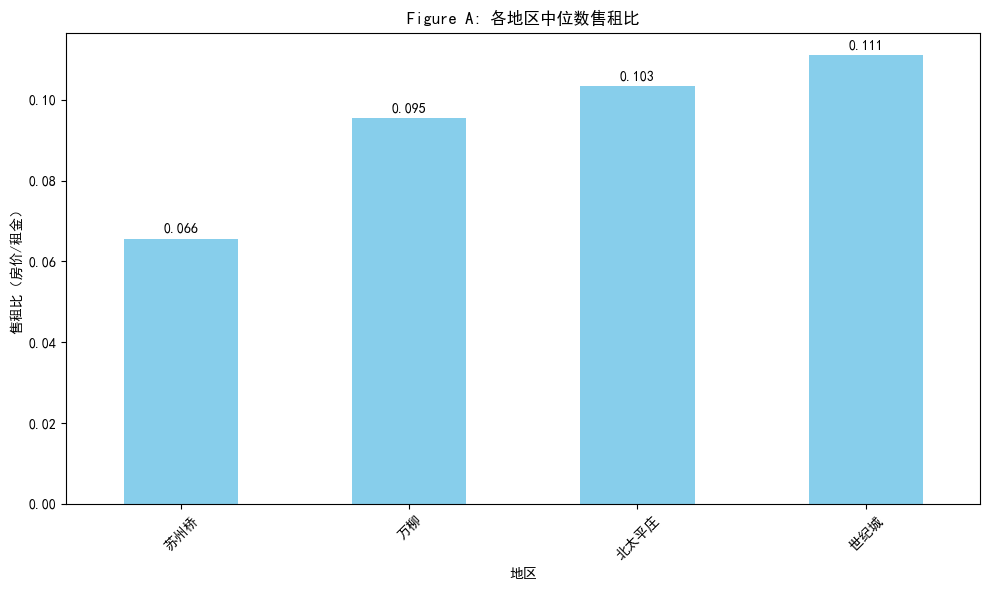

In [7]:
##3-3 figure A
# 导入pandas库
import pandas as pd
import numpy as np

# 读取租房数据
df_rent = pd.read_csv(url1)
df_rent.columns = df_rent.columns.str.strip()
df_rent['价格'] = pd.to_numeric(df_rent['价格'], errors='coerce')

# 计算各地区租房价格中位数
rent_median = df_rent.groupby('地区')['价格'].median()

# 读取二手房数据
df_sale = pd.read_csv(url2)
df_sale.columns = df_sale.columns.str.strip()
df_sale['价格'] = pd.to_numeric(df_sale['价格'], errors='coerce')

# 计算各地区二手房价格中位数
sale_median = df_sale.groupby('地区')['价格'].median()

# 检查是否有租金为0的情况
print("租金为0或NaN的地区：", rent_median[rent_median <= 0].index.tolist())

# 安全计算售租比，避免除以0
sale_rent_ratio = sale_median.div(rent_median.replace(0, np.nan))

# 按售租比排序
sorted_ratio = sale_rent_ratio.sort_values()

# 输出结果
print("📊 各地区中位数售租比（房价/租金）：")
print(sorted_ratio)

# 尝试不使用plt.show()先看看是否会崩溃
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

fig, ax = plt.subplots(figsize=(10, 6))
bars = sorted_ratio.plot(kind='bar', ax=ax, color='skyblue')

ax.set_title('Figure A: 各地区中位数售租比')
ax.set_ylabel('售租比（房价/租金）')
plt.xticks(rotation=45)

# 添加数据标签
for i, value in enumerate(sorted_ratio):
    ax.text(i, value + 0.001, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Model 1 R²: 0.5804317612221762
Model 2 R²: 0.2682838464518734


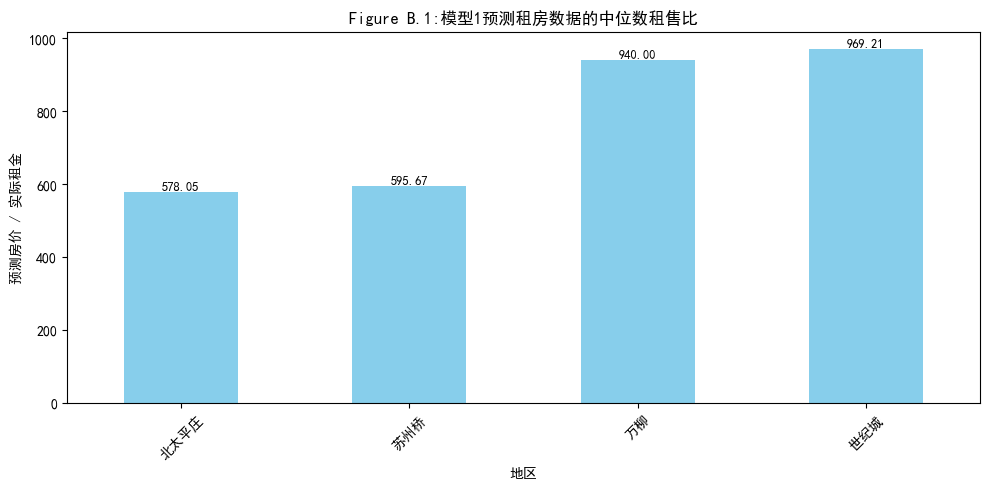

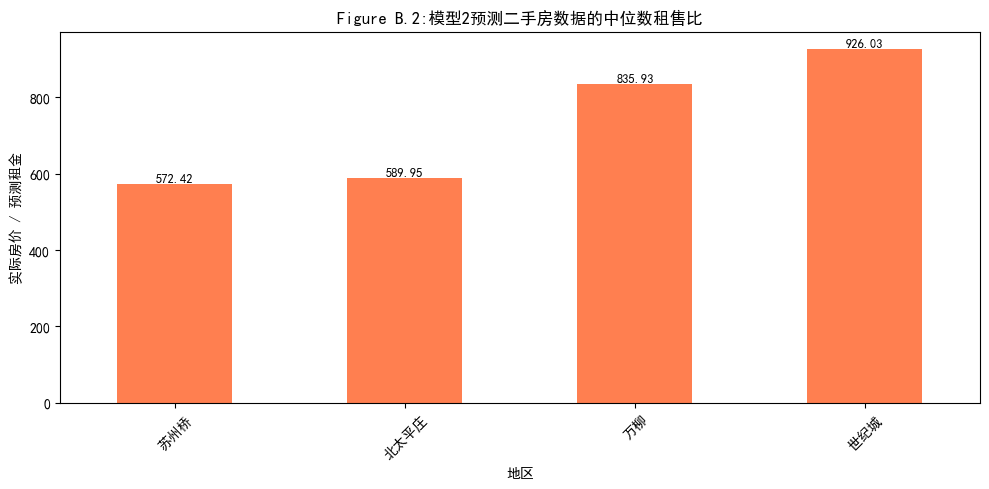

In [8]:
## 3-4建模并预测
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df_sale = pd.read_csv(url2)
df_rent = pd.read_csv(url1)

# 清洗列名和字段
for df in [df_sale, df_rent]:
    df.columns = df.columns.str.strip()
    df['面积(㎡)'] = pd.to_numeric(df['面积(㎡)'], errors='coerce')
    df['价格'] = pd.to_numeric(df['价格'], errors='coerce')
    df['单价(元/㎡)'] = pd.to_numeric(df['单价(元/㎡)'], errors='coerce')
    df['地区'] = df['地区'].astype(str).str.strip()
    df['名称'] = df['名称'].astype(str).str.strip()
    df.dropna(subset=['面积(㎡)', '价格', '单价(元/㎡)', '地区', '名称'], inplace=True)

# 编码地区变量
df_sale_encoded = pd.get_dummies(df_sale, columns=['地区'], drop_first=True)
df_rent_encoded = pd.get_dummies(df_rent, columns=['地区'], drop_first=True)

# 模型1：用二手房数据预测房价
X1 = df_sale_encoded[['面积(㎡)'] + [col for col in df_sale_encoded.columns if col.startswith('地区_')]]
X1 = sm.add_constant(X1).astype(float)
y1 = df_sale_encoded['单价(元/㎡)'].astype(float)
model1 = sm.OLS(y1, X1).fit()

# 用模型1预测租房数据的房价
X_rent_for_price = df_rent_encoded[['面积(㎡)'] + [col for col in df_rent_encoded.columns if col.startswith('地区_')]]
X_rent_for_price = sm.add_constant(X_rent_for_price).astype(float)
df_rent['pred_price_per_m2'] = model1.predict(X_rent_for_price)

# 计算租房数据的租售比（预测房价 ÷ 实际租金）
df_rent['ratio_model1'] = df_rent['pred_price_per_m2'] / df_rent['单价(元/㎡)']
median_ratio_model1 = df_rent.groupby('地区')['ratio_model1'].median().sort_values()

# 模型2：用租房数据预测租金
X2 = df_rent_encoded[['面积(㎡)'] + [col for col in df_rent_encoded.columns if col.startswith('地区_')]]
X2 = sm.add_constant(X2).astype(float)
y2 = df_rent_encoded['单价(元/㎡)'].astype(float)
model2 = sm.OLS(y2, X2).fit()

# 用模型2预测二手房数据的租金
X_sale_for_rent = df_sale_encoded[['面积(㎡)'] + [col for col in df_sale_encoded.columns if col.startswith('地区_')]]
X_sale_for_rent = sm.add_constant(X_sale_for_rent).astype(float)
df_sale['pred_rent_per_m2'] = model2.predict(X_sale_for_rent)

# 计算二手房数据的租售比（实际房价 ÷ 预测租金）
df_sale['ratio_model2'] = df_sale['单价(元/㎡)'] / df_sale['pred_rent_per_m2']
median_ratio_model2 = df_sale.groupby('地区')['ratio_model2'].median().sort_values()

# 打印 R² 对比
print("Model 1 R²:", model1.rsquared)
print("Model 2 R²:", model2.rsquared)

# 图1：模型1预测租房数据的租售比
plt.figure(figsize=(10, 5))
ax1 = median_ratio_model1.plot(kind='bar', color='skyblue')
plt.title('Figure B.1:模型1预测租房数据的中位数租售比')
plt.ylabel('预测房价 / 实际租金')
plt.xticks(rotation=45)
for i, value in enumerate(median_ratio_model1):
    ax1.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# 图2：模型2预测二手房数据的租售比
plt.figure(figsize=(10, 5))
ax2 = median_ratio_model2.plot(kind='bar', color='coral')
plt.title('Figure B.2:模型2预测二手房数据的中位数租售比')
plt.ylabel('实际房价 / 预测租金')
plt.xticks(rotation=45)
for i, value in enumerate(median_ratio_model2):
    ax2.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()



Model 1 R²: 0.6412970436084435
Model 2 R²: 0.34700810278751015


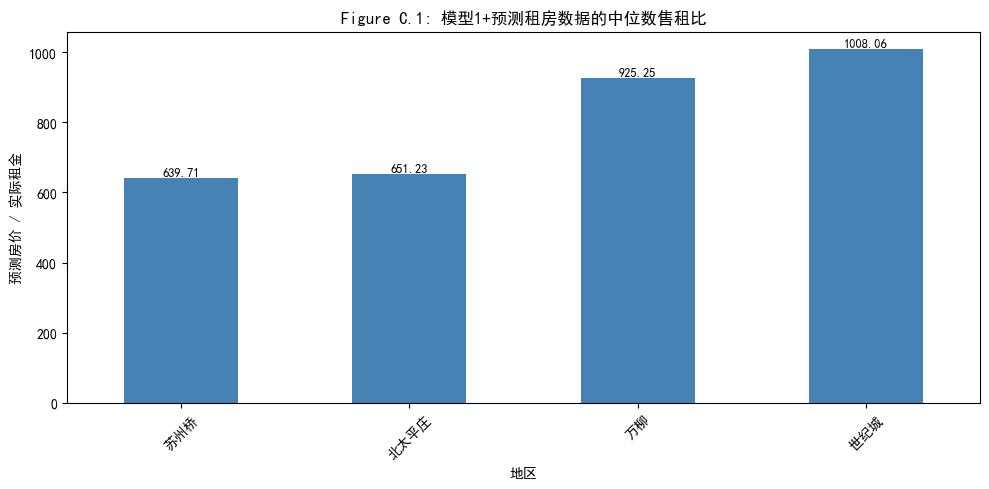

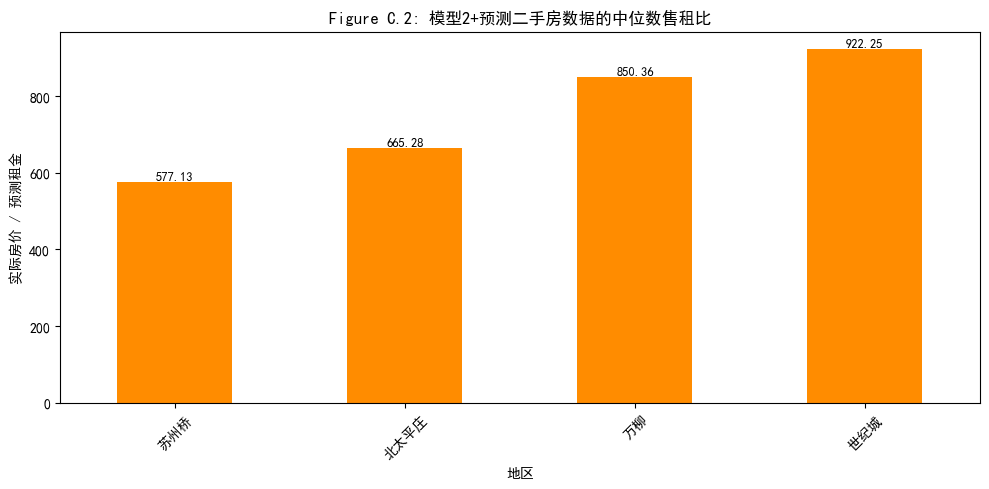

In [10]:
## 3-5建模
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df_sale = pd.read_csv(url2)
df_rent = pd.read_csv(url1)

# 清洗列名和字段
for df in [df_sale, df_rent]:
    df.columns = df.columns.str.strip()
    df['面积(㎡)'] = pd.to_numeric(df['面积(㎡)'], errors='coerce')
    df['价格'] = pd.to_numeric(df['价格'], errors='coerce')
    df['单价(元/㎡)'] = pd.to_numeric(df['单价(元/㎡)'], errors='coerce')
    df['地区'] = df['地区'].astype(str).str.strip()
    df['名称'] = df['名称'].astype(str).str.strip()
    df.dropna(subset=['面积(㎡)', '价格', '单价(元/㎡)', '地区', '名称'], inplace=True)

# 编码地区变量
df_sale_encoded = pd.get_dummies(df_sale, columns=['地区'], drop_first=True)
df_rent_encoded = pd.get_dummies(df_rent, columns=['地区'], drop_first=True)

# 添加面积²
df_sale_encoded['面积²'] = df_sale_encoded['面积(㎡)'] ** 2
df_rent_encoded['面积²'] = df_rent_encoded['面积(㎡)'] ** 2

# 添加交互项：面积 × 地区
for col in df_sale_encoded.columns:
    if col.startswith('地区_'):
        df_sale_encoded[f'{col}_交互'] = df_sale_encoded['面积(㎡)'] * df_sale_encoded[col]
for col in df_rent_encoded.columns:
    if col.startswith('地区_'):
        df_rent_encoded[f'{col}_交互'] = df_rent_encoded['面积(㎡)'] * df_rent_encoded[col]

# 模型1+：预测房价
X1_plus = df_sale_encoded[['面积(㎡)', '面积²'] + [col for col in df_sale_encoded.columns if col.startswith('地区_') or col.endswith('_交互')]]
X1_plus = sm.add_constant(X1_plus).astype(float)
y1 = df_sale_encoded['单价(元/㎡)'].astype(float)
model1_plus = sm.OLS(y1, X1_plus).fit()

# 模型2+：预测租金
X2_plus = df_rent_encoded[['面积(㎡)', '面积²'] + [col for col in df_rent_encoded.columns if col.startswith('地区_') or col.endswith('_交互')]]
X2_plus = sm.add_constant(X2_plus).astype(float)
y2 = df_rent_encoded['单价(元/㎡)'].astype(float)
model2_plus = sm.OLS(y2, X2_plus).fit()

# 打印 R² 对比
print("Model 1 R²:", model1_plus.rsquared)
print("Model 2 R²:", model2_plus.rsquared)

# 预测
df_rent['pred_price_plus'] = model1_plus.predict(X2_plus)
df_sale['pred_rent_plus'] = model2_plus.predict(X1_plus)

# 计算售租比
df_rent['ratio_plus'] = df_rent['pred_price_plus'] / df_rent['单价(元/㎡)']
df_sale['ratio_plus'] = df_sale['单价(元/㎡)'] / df_sale['pred_rent_plus']

# 分别计算租房数据和二手房数据的中位数售租比
median_ratio_plus_rent = df_rent.groupby('地区')['ratio_plus'].median().sort_values()
median_ratio_plus_sale = df_sale.groupby('地区')['ratio_plus'].median().sort_values()

# 图像 1：模型1+预测租房数据的售租比
plt.figure(figsize=(10, 5))
ax1 = median_ratio_plus_rent.plot(kind='bar', color='steelblue')
plt.title('Figure C.1: 模型1+预测租房数据的中位数售租比')
plt.ylabel('预测房价 / 实际租金')
plt.xticks(rotation=45)
for i, v in enumerate(median_ratio_plus_rent):
    ax1.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# 图像 2：模型2+预测二手房数据的售租比
plt.figure(figsize=(10, 5))
ax2 = median_ratio_plus_sale.plot(kind='bar', color='darkorange')
plt.title('Figure C.2: 模型2+预测二手房数据的中位数售租比')
plt.ylabel('实际房价 / 预测租金')
plt.xticks(rotation=45)
for i, v in enumerate(median_ratio_plus_sale):
    ax2.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [12]:
print("模型1 R²:", model1.rsquared)
print("模型2 R²:", model2.rsquared)
print("模型1+ R²:", model1_plus.rsquared)
print("模型2+ R²:", model2_plus.rsquared)

if model1_plus.rsquared > model1.rsquared:
    print("✅ 模型1+的R²更高，模型改进有效。")
else:
    print("⚠️ 模型1+的R²不如模型1，模型改进无效。")

if model2_plus.rsquared > model2.rsquared:
    print("✅ 模型2+的R²更高，模型改进有效。")
else:
    print("⚠️ 模型2+的R²不如模型2，模型改进无效。")


模型1 R²: 0.5804317612221762
模型2 R²: 0.2682838464518734
模型1+ R²: 0.6412970436084435
模型2+ R²: 0.34700810278751015
✅ 模型1+的R²更高，模型改进有效。
✅ 模型2+的R²更高，模型改进有效。
